# Stock Price Forecasting
<h5>Name : Rejey Ezekiel
</br>Class : DAAA/FT/1B/01
</br>Admin No. : 2348935</h5>

## Introduction
Analysis on 3 stocks and thier prices from 2018 to 2023


<hr>
<h3>Importing Libraries</h3>
<hr></hr>

In [198]:
# Basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import itertools
from tqdm import tqdm

# Metrics
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error

# Models
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# EDA + Model Selection
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.stattools import adfuller

# Pickle Library = Saving Models 
import pickle

import warnings

# Suppress FutureWarning for 'M' alias
warnings.simplefilter(action='ignore', category=FutureWarning)

sns.set_theme(palette='colorblind')

In [176]:
df_train = pd.read_csv('./Dataset/CA2-Stock-Price-Data.csv')

In [177]:
df_outline = df_train.copy()

In [178]:
descriptive_stats = df_outline.describe(include="all").T
descriptive_stats["Proportion of Most Frequent Value"] = (
    descriptive_stats["freq"] / len(df_outline) * 100
)
descriptive_stats.sort_values("Proportion of Most Frequent Value", ascending=False)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max,Proportion of Most Frequent Value
Date,1257,1257,10/1/2018,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.079554
Apple,1257.0,NaN,NaN,NaN,116.168385,46.945568,35.547501,66.592499,129.610001,152.589996,196.449997,NaN
Amazon,1257.0,NaN,NaN,NaN,124.791237,32.495925,67.197998,93.489998,120.970001,158.100494,186.570496,NaN
DBS,1257.0,NaN,NaN,NaN,28.185863,4.738732,16.879999,24.879999,28.65,32.48,37.25,NaN


In [179]:
df_train["Date"] = pd.to_datetime(df_train["Date"])
df_train.set_index("Date", inplace=True)
df_train = df_train.asfreq('D')
df_train.interpolate(inplace=True)


In [180]:
df_train

,Apple,Amazon,DBS
Date,,,
2018-10-01,56.814999,100.218002,25.969999
2018-10-02,57.320000,98.565498,25.629999
2018-10-03,58.017502,97.638000,25.950001
2018-10-04,56.997501,95.471001,25.760000
2018-10-05,56.072498,94.482498,25.770000
...,...,...,...
2023-09-24,175.649999,130.553334,33.383334
2023-09-25,176.080002,131.270004,33.450001
2023-09-26,171.960007,125.980003,33.509998


In [181]:
df_for_EDA = df_train.copy()

In [182]:
df_train


,Apple,Amazon,DBS
Date,,,
2018-10-01,56.814999,100.218002,25.969999
2018-10-02,57.320000,98.565498,25.629999
2018-10-03,58.017502,97.638000,25.950001
2018-10-04,56.997501,95.471001,25.760000
2018-10-05,56.072498,94.482498,25.770000
...,...,...,...
2023-09-24,175.649999,130.553334,33.383334
2023-09-25,176.080002,131.270004,33.450001
2023-09-26,171.960007,125.980003,33.509998


In [183]:
df_for_EDA.isnull().sum()

Apple     0
Amazon    0
DBS       0
dtype: int64

In [184]:
df_for_EDA.columns

Index(['Apple', 'Amazon', 'DBS'], dtype='object')

In [185]:
df_for_EDA.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1824 entries, 2018-10-01 to 2023-09-28
Freq: D
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Apple   1824 non-null   float64
 1   Amazon  1824 non-null   float64
 2   DBS     1824 non-null   float64
dtypes: float64(3)
memory usage: 57.0 KB


In [186]:
df_for_EDA.isnull().sum()
df_for_EDA.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1824 entries, 2018-10-01 to 2023-09-28
Freq: D
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Apple   1824 non-null   float64
 1   Amazon  1824 non-null   float64
 2   DBS     1824 non-null   float64
dtypes: float64(3)
memory usage: 57.0 KB


In [187]:
# Check for missing intervals
pd.date_range(start = '2018-10-01', end = '2023-09-28', freq='MS').difference(df_for_EDA.index)

DatetimeIndex([], dtype='datetime64[ns]', freq='MS')

In [188]:
df_train.head(20)

,Apple,Amazon,DBS
Date,,,
2018-10-01,56.814999,100.218002,25.969999
2018-10-02,57.320000,98.565498,25.629999
2018-10-03,58.017502,97.638000,25.950001
2018-10-04,56.997501,95.471001,25.760000
2018-10-05,56.072498,94.482498,25.770000
2018-10-06,56.029166,94.061999,25.670000
2018-10-07,55.985833,93.641500,25.569999
2018-10-08,55.942501,93.221001,25.469999
2018-10-09,56.717499,93.515999,25.260000


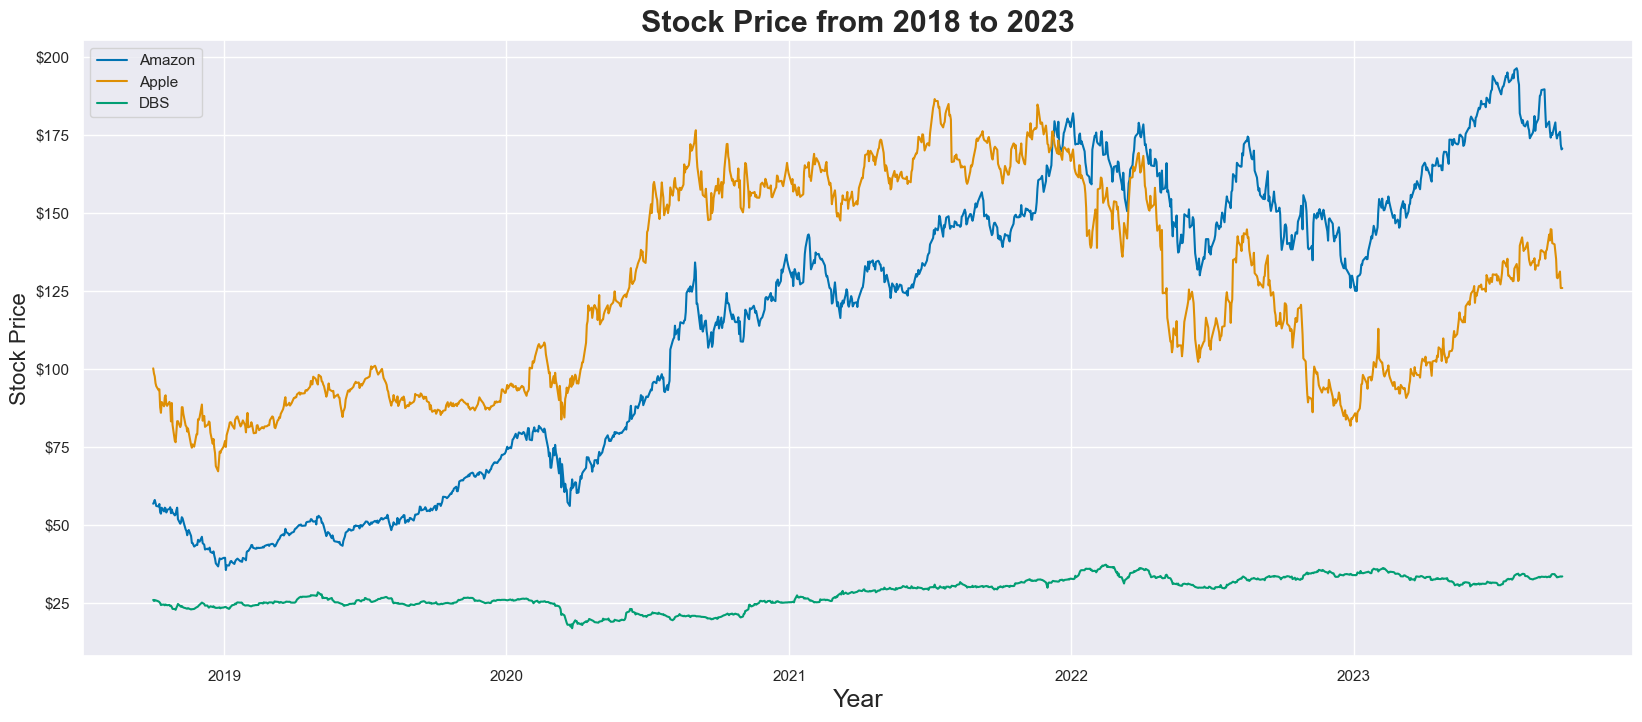

In [189]:
plt.figure(figsize=(20,8))

for column in df_for_EDA.columns:
    plt.plot(df_for_EDA.index,df_for_EDA[column])

plt.legend(np.unique(df_for_EDA.columns),fancybox=True)

plt.xlabel('Year',fontsize=18)

# Add dollar sign to y-axis ticks
formatter = ticker.FormatStrFormatter('$%1.0f')
plt.gca().yaxis.set_major_formatter(formatter)

plt.ylabel('Stock Price',fontsize=16)
plt.title('Stock Price from 2018 to 2023',fontsize=22,fontweight='bold')

plt.show()

<h2>Univariate Analysis</h2>

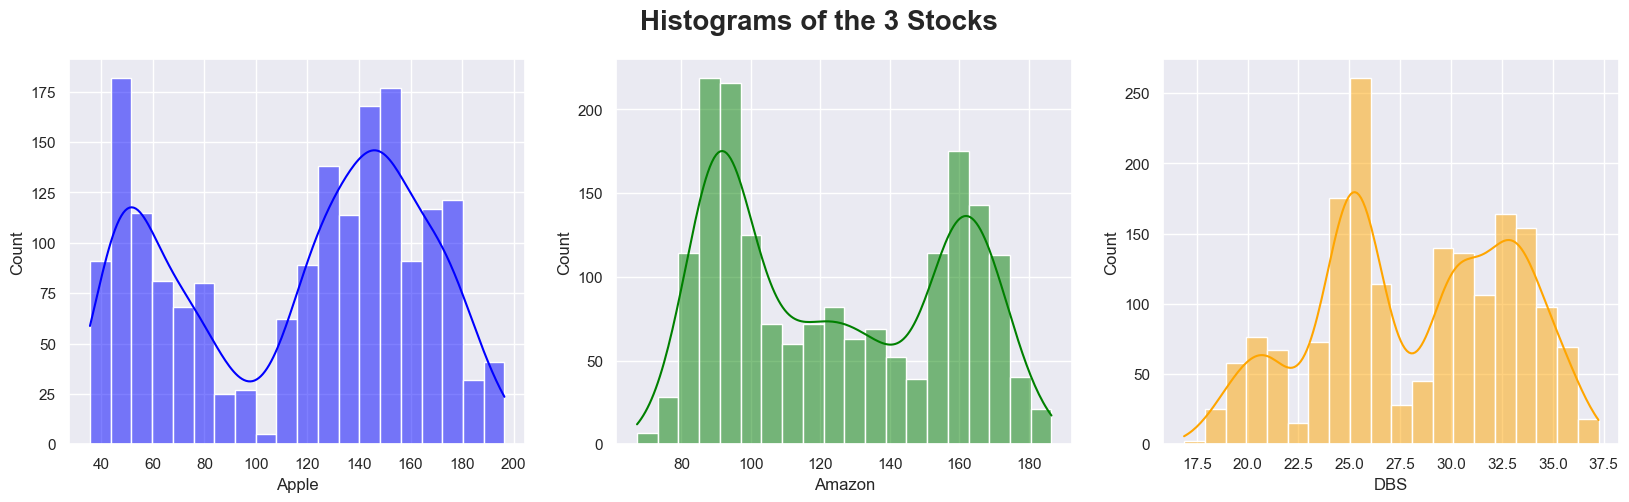

In [190]:
# Histplot 
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

sns.histplot(data=df_for_EDA, x='Apple', ax=ax[0], kde=True, bins=20, color='blue')
sns.histplot(data=df_for_EDA, x='Amazon', ax=ax[1], kde=True, bins=20,color='green')
sns.histplot(data=df_for_EDA, x='DBS', ax=ax[2], kde=True, bins=20,color='orange')
plt.suptitle('Histograms of the 3 Stocks', fontsize=20, fontweight='bold')

plt.show()

In [192]:
maxlag = 12
test = "ssr_chi2test"

g_matrix = pd.DataFrame(
    np.zeros((len(df_for_EDA.columns), len(df_for_EDA.columns))),
    columns=df_for_EDA.columns,
    index=df_for_EDA.columns,
)

for c in g_matrix.columns:
    for r in g_matrix.index:
        test_result = grangercausalitytests(
            df_for_EDA[[r, c]], maxlag=maxlag, verbose=False
        )
        p_values = [round(test_result[i + 1][0][test][1], 4) for i in range(maxlag)]
        min_p_value = np.min(p_values)
        g_matrix.loc[r, c] = min_p_value
g_matrix.columns = [var + "_x" for var in df_for_EDA.columns]
g_matrix.index = [var + "_y" for var in df_for_EDA.columns]

g_matrix


,Apple_x,Amazon_x,DBS_x
Apple_y,1.0000,0.0299,0.0032
Amazon_y,0.1035,1.0000,0.0055
DBS_y,0.0021,0.0022,1.0000


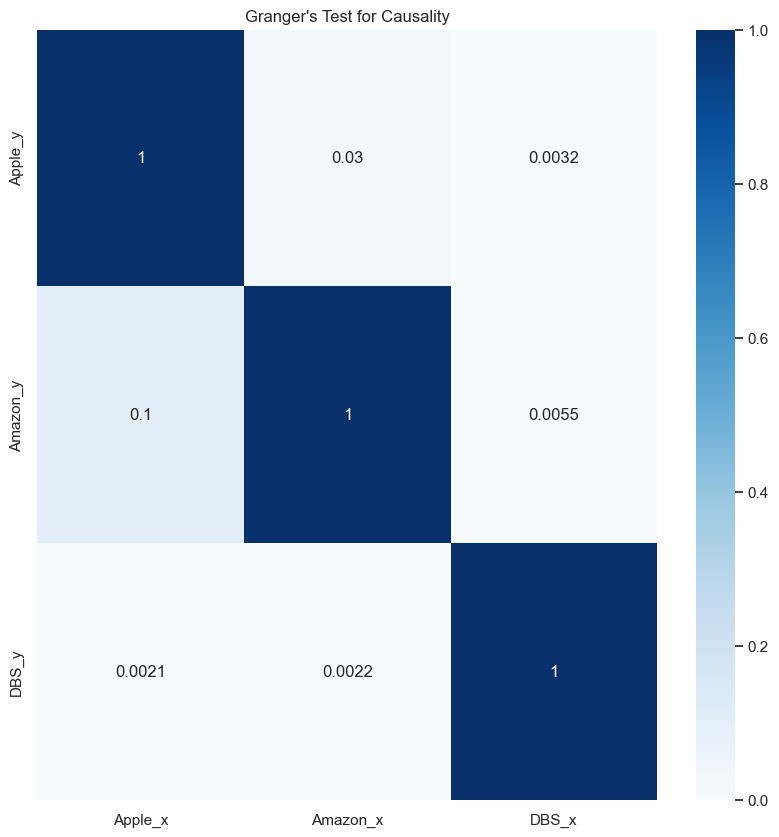

In [193]:
plt.figure(figsize=(10, 10))
sns.heatmap(g_matrix, annot=True, cmap="Blues", vmin=0, vmax=1)
plt.title("Granger's Test for Causality")
plt.show()

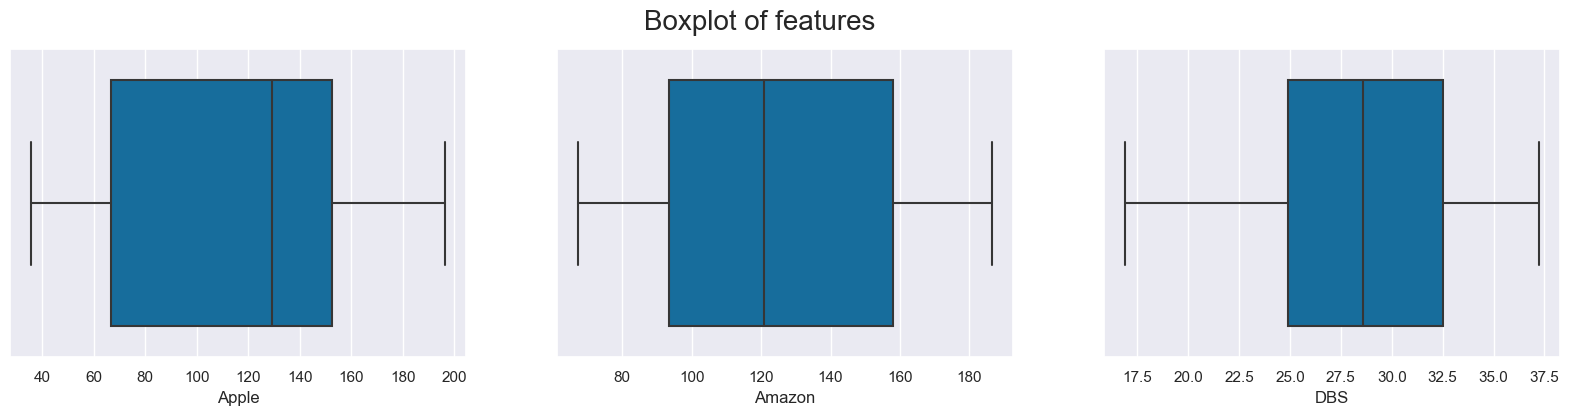

In [194]:
# Boxplots
fig, axes = plt.subplots(1, 3, figsize=(20, 4))
for ax, col in zip(axes, df_for_EDA.columns):
    sns.boxplot(data=df_for_EDA, x=col, ax = ax)
    
plt.suptitle('Boxplot of features', fontsize=20)
plt.show()

Our dataset dose not consist of outliers but is skewed.

<hr></hr>
<h3>Time Series Analysis</h3>
<hr></hr>

Seasonal Decomposition
Column: Apple
Seasonal 7


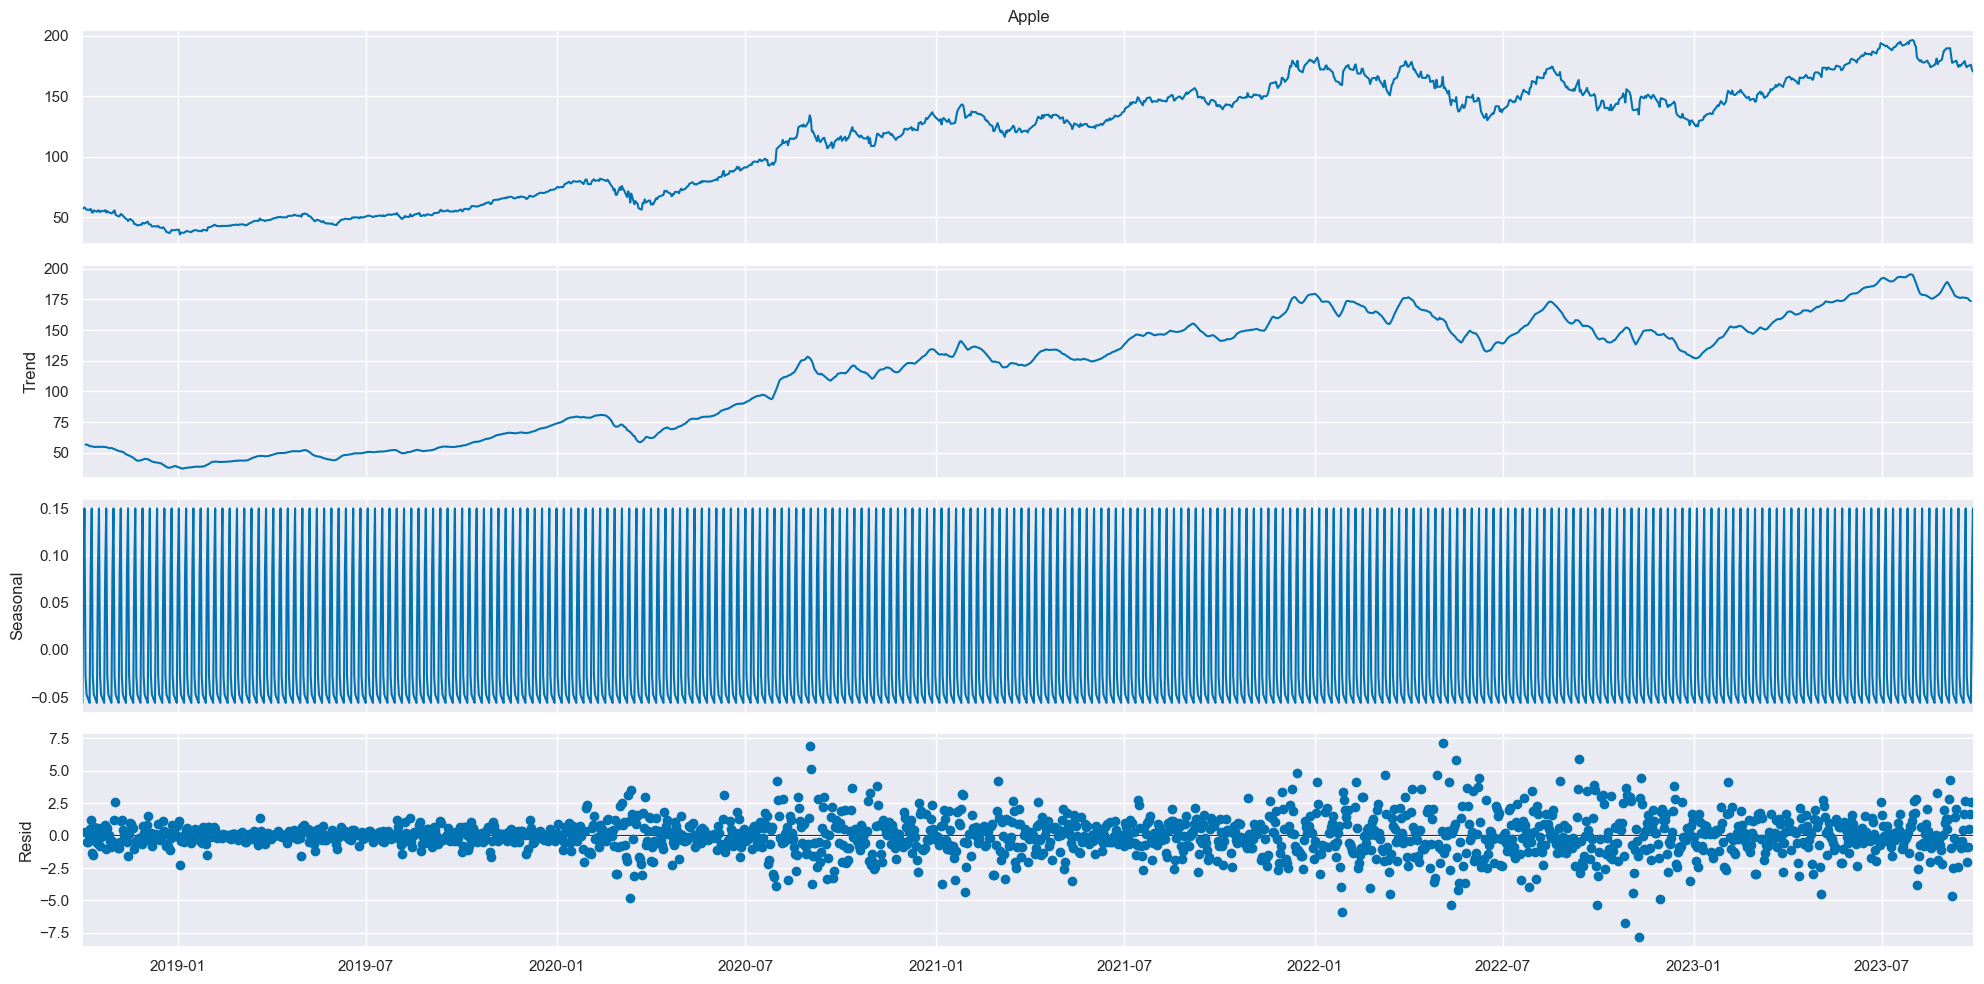

Seasonal Decomposition
Column: Amazon
Seasonal 7


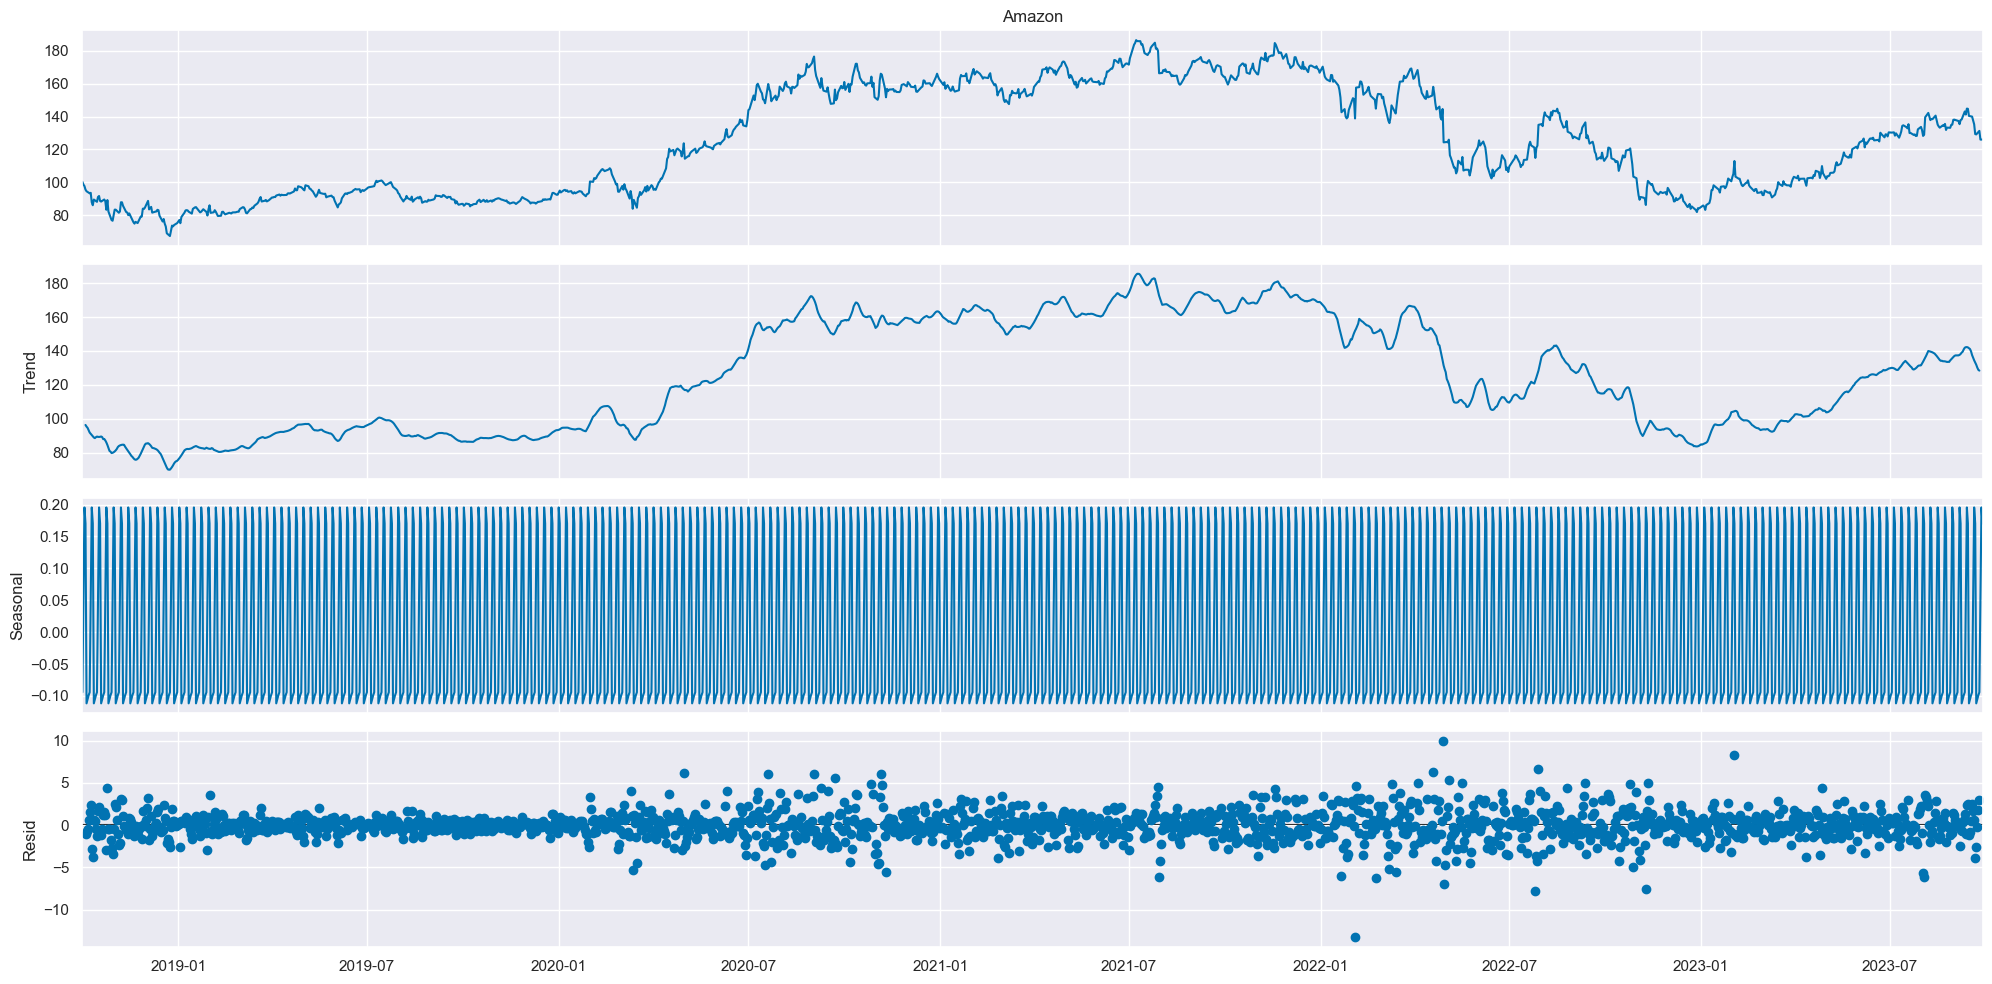

Seasonal Decomposition
Column: DBS
Seasonal 7


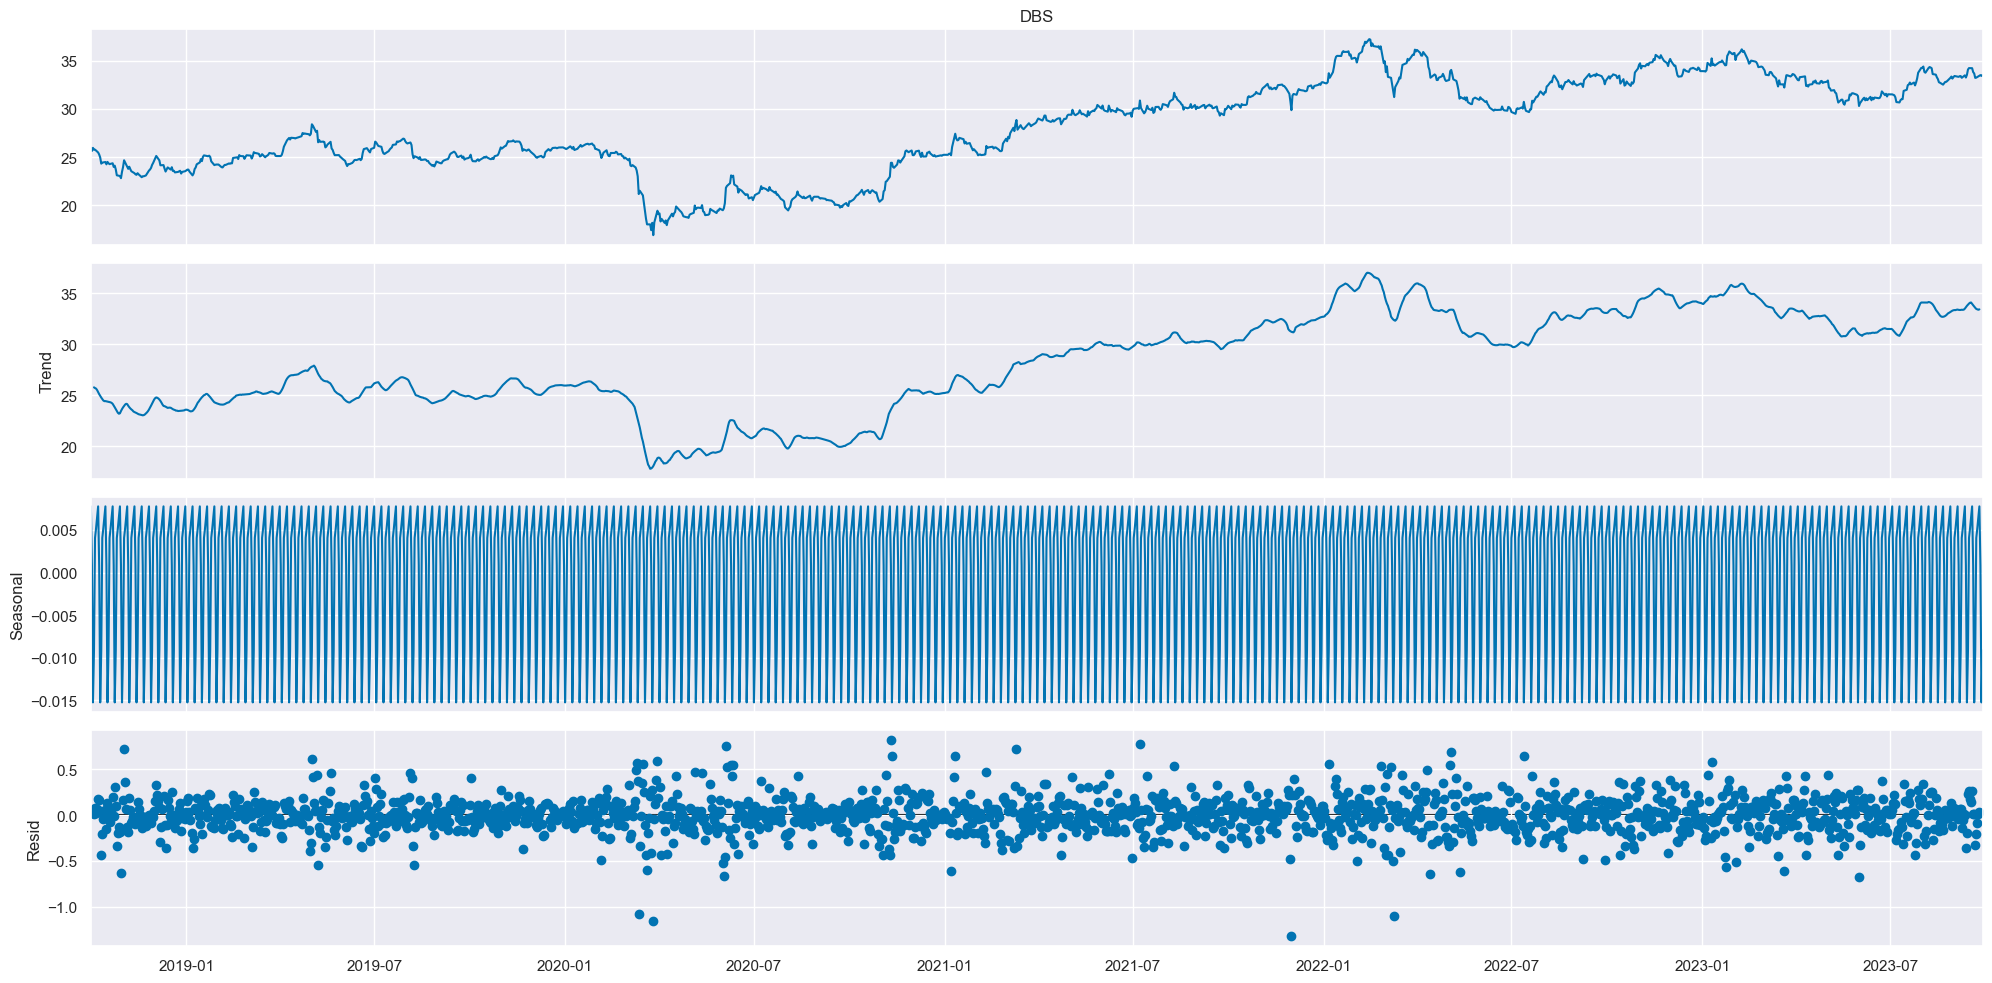

In [195]:
for i in df_for_EDA.columns:
    plt.rc("figure", figsize=(20, 10))
    print("Seasonal Decomposition\nColumn:", i)
    decomposition = seasonal_decompose(df_for_EDA[i], model='additive')
    print("Seasonal", len(decomposition.seasonal.drop_duplicates()))
    decomposition.plot()
    plt.show()

ADF Statistic for Apple: -0.950256107301491


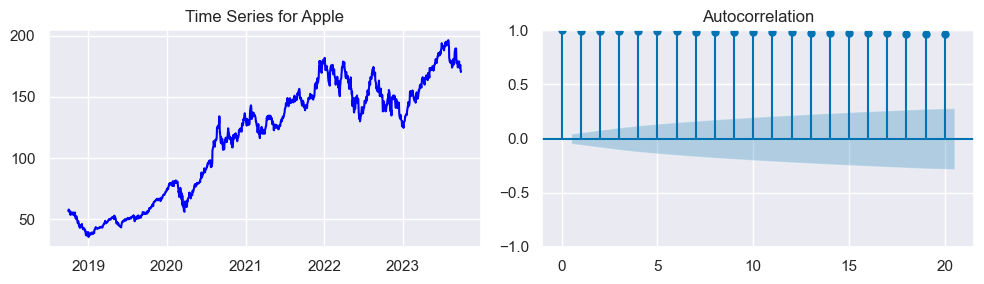

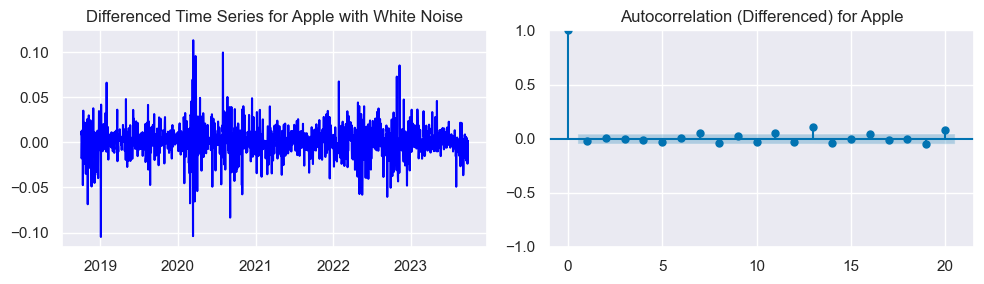

p-value original: 0.7709724201418943
p-value after differencing: 1.3877411376078453e-13
p-value of Ljung-Box Test before differencing: 0.0
p-value of Ljung_Box Test after differencing: 1.6006514721576408e-06
Stationary
Accept Alternative Hypothesis
**********************************************************************

ADF Statistic for Amazon: -1.674520409361892


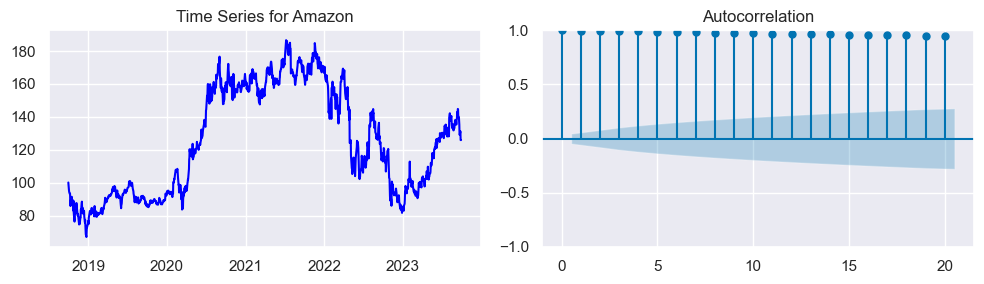

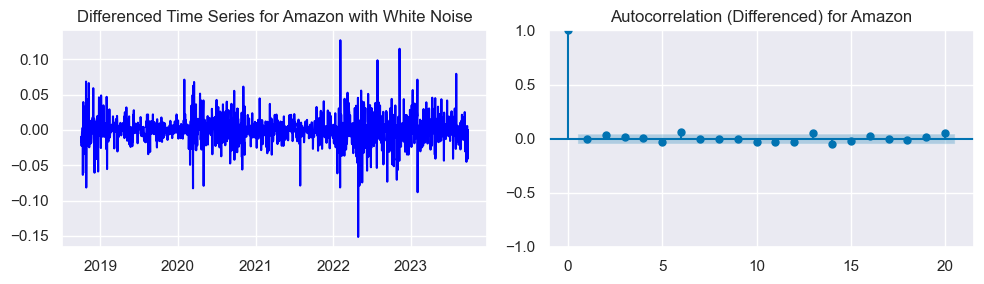

p-value original: 0.4442858184379813
p-value after differencing: 1.9364601798705975e-29
p-value of Ljung-Box Test before differencing: 0.0
p-value of Ljung_Box Test after differencing: 0.028718875679789427
Stationary
Accept Alternative Hypothesis
**********************************************************************

ADF Statistic for DBS: -1.3178591523935927


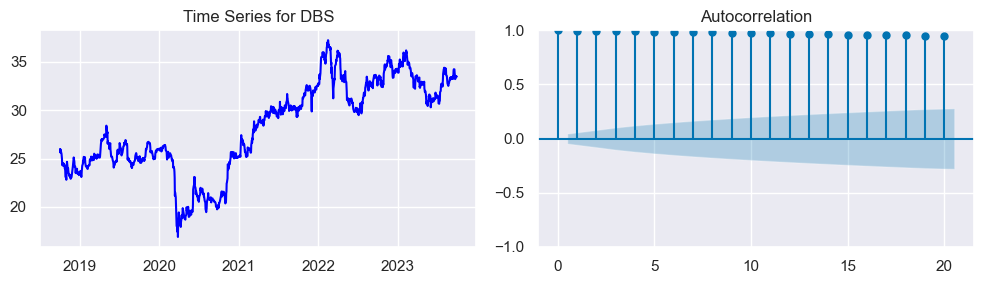

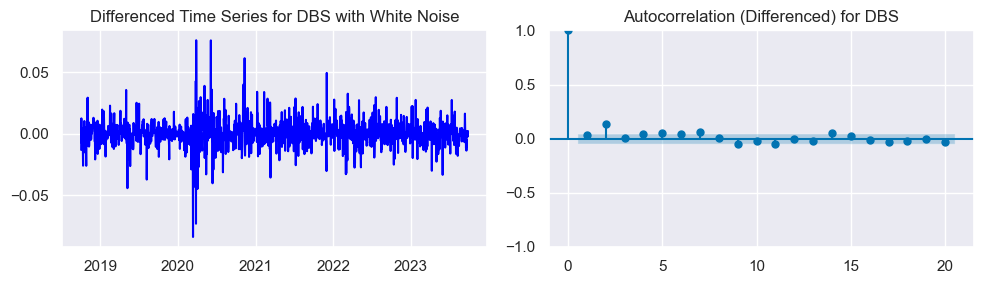

p-value original: 0.620962641148566
p-value after differencing: 5.100898967790073e-25
p-value of Ljung-Box Test before differencing: 0.0
p-value of Ljung_Box Test after differencing: 3.730858974541032e-08
Stationary
Accept Alternative Hypothesis
**********************************************************************



In [154]:
# Differencing transformation

for df in df_for_EDA.columns:

    plt.figure(figsize=(10, 3))

    # Time series plot
    plt.subplot(1, 2, 1)
    plt.plot(df_for_EDA[df], linestyle='-', marker='', color='blue')
    plt.title(f'Time Series for {df}')

    # Correlogram (ACF plot)
    plt.subplot(1, 2, 2)
    plot_acf(df_for_EDA[df], ax=plt.gca(), lags=20,label=df)
    plt.tight_layout()

    # Display the plots
    adf_result = adfuller(df_for_EDA[df])
    print(f'ADF Statistic for {df}: {adf_result[0]}')

    plt.show()
    
    x_diff = np.log(df_for_EDA[df]).diff().dropna()

    # Plotting the Differenced time series and its ACF side-by-side
    plt.figure(figsize=(10, 3))

    # Differenced time series plot
    plt.subplot(1, 2, 1)
    plt.plot(x_diff, linestyle='-', color='blue')
    plt.title(f'Differenced Time Series for {df} with White Noise')

    # ACF plot for Differenced series
    plt.subplot(1, 2, 2)
    plot_acf(x_diff, ax=plt.gca(), lags=20)
    plt.title(f'Autocorrelation (Differenced) for {df}')

    plt.tight_layout()
    plt.show()

    adf_result_original = adfuller(df_for_EDA[df])
    p_value_original = adf_result_original[1]

    # ADF test for the differenced series
    adf_result_differenced = adfuller(x_diff)
    p_value_differenced = adf_result_differenced[1]

    print(f"p-value original: {p_value_original}\np-value after differencing: {p_value_differenced}")

        # Ljung-Box test for the original series
    lb_result_original = acorr_ljungbox(df_for_EDA[df], lags=[20], return_df=True)
    single_p_value_original = lb_result_original['lb_pvalue'].iloc[0]

    # Ljung-Box test for the differenced series
    lb_result_differenced = acorr_ljungbox(x_diff, lags=[20], return_df=True)
    single_p_value_differenced = lb_result_differenced['lb_pvalue'].iloc[0]

    print(f"p-value of Ljung-Box Test before differencing: {single_p_value_original}")
    print(f"p-value of Ljung_Box Test after differencing: {single_p_value_differenced}")
    if p_value_differenced <= 0.05:
        print("Stationary")
    else:
        print("Non - Stationary")

    if single_p_value_differenced > 0.05:
        print("Failed to Reject Null Hypothesis")
    else:
        print("Accept Alternative Hypothesis")
    print("*" * 70 + "\n")

* H0 : Autocorrelation is zero
* H1 : Autocorrelation is not zero

After differencing, the series's autocorrelation is zero (i.e. has no autocorrelations) as p-value > 0.05 (fail to reject H0).

In [155]:
# Function to get P-Value for each variable in the dataset
def addfuller_test(df):
    p_value = []
    for col in df.columns:
        p_value.append(adfuller(df[col])[1]) # Run Adfuller test to determine is the time-series Stationary
        
    log = pd.DataFrame(dict(Variable = df.columns,P_Value = p_value, Stationary = [p<0.05 for p in p_value]))
    return log

addfuller_test(df_for_EDA)

,Variable,P_Value,Stationary
0,Apple,0.770972,False
1,Amazon,0.444286,False
2,DBS,0.620963,False


<hr>
<h4>Preparing Model Train and Testing Set Splitting</h4>
<hr>

In [156]:
df_train['Amazon'] = np.log(df_train['Amazon'])

In [157]:
# Split data into train and test
train_data = df_train.iloc[:-365]
test_data = df_train.iloc[-365:]

In [158]:
# Function to evaluate model
def expanding_window(model, endog, test_size=365, n_splits=3, **kwargs):
    tscv = TimeSeriesSplit(test_size=test_size, n_splits = n_splits)
    rmse_hist = []
    mape_hist = []
    aic_hist = []
    for idx, (train_index, test_index) in enumerate(tscv.split(endog)):
        warnings.filterwarnings("ignore")
        res = model(endog.iloc[train_index], **kwargs).fit()
        yhat = res.forecast(test_size)
        ytrue = endog.iloc[test_index]
        rmse_hist.append(mean_squared_error(ytrue, yhat, squared=False))
        mape_hist.append(mean_absolute_percentage_error(ytrue, yhat))
        aic_hist.append(res.aic)
    return np.array(rmse_hist).mean(), np.array(mape_hist).mean(), np.array(aic_hist).mean()

In [159]:
def expanding_window_baseline(endog:pd.Series, test_size=365, n_splits=3):
    tscv = TimeSeriesSplit(test_size=test_size, n_splits = n_splits)
    rmse_hist = []
    mape_hist = []
    
    for iters, (train_index, test_index) in enumerate(tscv.split(endog)):     
        train = endog.iloc[train_index]
        test = endog.iloc[test_index]
        yhat = pd.Series(train.mean()).repeat(test_size)
        
        rmse_hist.append(mean_squared_error(test.values, yhat.values, squared=False))
        mape_hist.append(mean_absolute_percentage_error(test.values, yhat.values))

    return np.array(rmse_hist).mean(), np.array(mape_hist).mean()

base_hist = dict()
for var in df_train.columns:
    base_hist[var] = expanding_window_baseline(endog=train_data[var])

pd.DataFrame(base_hist, index = ['baseline_rmse', 'baseline_mape']).T

,baseline_rmse,baseline_mape
Apple,59.540546,0.445518
Amazon,0.366255,0.064223
DBS,5.420699,0.174939


In [160]:
Apple_Results = dict()

for p in tqdm(range(10)):
    for q in range(10):
            rmse, mape, aic = expanding_window(ARIMA, train_data['Apple'], order=(p,1,q))
            Apple_Results['({},{},{})'.format(p,1,q)] = [rmse, mape, aic]
            
pd.DataFrame(Apple_Results).T.rename(columns = {0:"RMSE", 1:"MAPE", 2:"AIC"}).sort_values(["MAPE"]).head(10)

100%|██████████| 10/10 [04:01<00:00, 24.17s/it]


,RMSE,MAPE,AIC
"(7,1,5)",18.529356,0.136256,2387.855412
"(4,1,5)",19.173093,0.137244,2389.527059
"(8,1,7)",19.367628,0.138980,2393.622148
"(7,1,8)",21.455927,0.140646,2392.489159
"(9,1,4)",19.751233,0.140930,2394.517242
"(9,1,5)",20.149271,0.141636,2393.032781
"(7,1,7)",20.022348,0.142172,2396.880274
"(5,1,4)",19.583991,0.142481,2392.038726
"(7,1,4)",20.397130,0.142568,2393.315874
"(6,1,7)",19.819070,0.143109,2391.195734


In [161]:
Amazon_Results = dict()

for p in tqdm(range(10)):
    for q in range(10):
            rmse, mape, aic = expanding_window(ARIMA, train_data['Amazon'], order=(p,0,q))
            Amazon_Results['({},{},{})'.format(p,1,q)] = [rmse, mape, aic]
            
pd.DataFrame(Amazon_Results).T.rename(columns = {0:"RMSE", 1:"MAPE", 2:"AIC"}).sort_values(["MAPE"]).head(10)

100%|██████████| 10/10 [08:19<00:00, 50.00s/it]


,RMSE,MAPE,AIC
"(4,1,6)",0.174702,0.026410,-3947.120270
"(3,1,6)",0.176386,0.026678,-3942.588851
"(5,1,2)",0.178728,0.026924,-3946.954613
"(2,1,6)",0.180248,0.027217,-3946.692720
"(2,1,3)",0.183526,0.027663,-3949.275480
"(4,1,0)",0.183669,0.027693,-3950.757354
"(4,1,5)",0.183955,0.027736,-3945.628541
"(4,1,1)",0.184558,0.027821,-3946.659640
"(5,1,1)",0.184578,0.027826,-3948.573802
"(7,1,2)",0.185181,0.027904,-3945.057919


In [162]:
dbs_Results = dict()

for p in tqdm(range(10)):
    for q in range(10):
            rmse, mape, aic = expanding_window(ARIMA, train_data['DBS'], order=(p,1,q))
            dbs_Results['({},{},{})'.format(p,1,q)] = [rmse, mape, aic]
            
pd.DataFrame(dbs_Results).T.rename(columns = {0:"RMSE", 1:"MAPE", 2:"AIC"}).sort_values(["MAPE"]).head(10)

100%|██████████| 10/10 [05:37<00:00, 33.72s/it]


,RMSE,MAPE,AIC
"(0,1,8)",4.791827,0.154624,-20.679468
"(1,1,7)",4.792566,0.154662,-20.547391
"(0,1,9)",4.796080,0.154767,-19.633545
"(1,1,8)",4.798365,0.154809,-19.501587
"(0,1,7)",4.796680,0.154811,-22.328624
"(2,1,7)",4.801743,0.155018,-21.710633
"(5,1,4)",4.804029,0.155045,-21.027317
"(8,1,1)",4.804525,0.155046,-18.191312
"(1,1,6)",4.807874,0.155117,-17.702912
"(7,1,3)",4.805226,0.155137,-19.053321


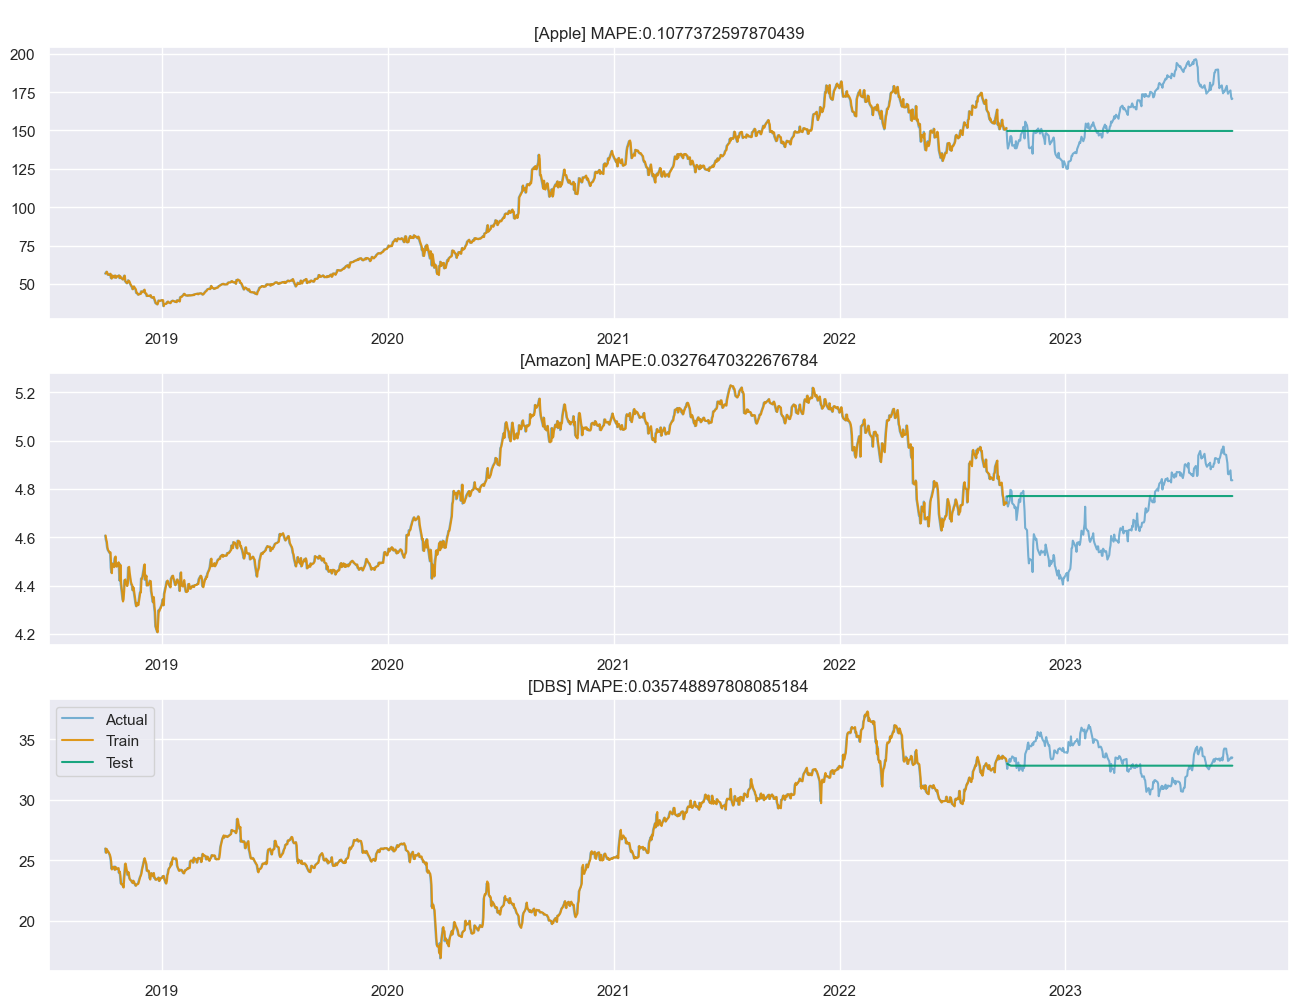

In [163]:
orders = [(7,1,5),(8,1,2),(0,1,8)]

fig, axes = plt.subplots(3,1, figsize=(16, 12))

for idx, order in enumerate(orders):
    mod = ARIMA(train_data[df_train.columns[idx]], order = order)
    res = mod.fit()

    full_pred = res.predict()
    pred = res.forecast(365)

    axes[idx].set_title("\n[{}] MAPE:{}".format(df_train.columns[idx], mean_absolute_percentage_error(test_data[df_train.columns[idx]],pred)))
    axes[idx].plot(df_train[df_train.columns[idx]], label = 'Actual', alpha=0.5)
    axes[idx].plot(full_pred.iloc[1:], label = 'Train', alpha=0.9)
    axes[idx].plot(pred, label='Test', alpha=0.9)
plt.legend()
plt.show()

In [164]:
sarima_gas_results = dict()

# Define Params Space
p_range = range(1,4)
d_range = [1]
q_range = range(1,4)
P_range = range(1,3)
D_range = [1]
Q_range = range(1,3)
m = [7]

for p, d, q, P, D, Q, m in tqdm(itertools.product(*(p_range, d_range, q_range, P_range, D_range, Q_range, m))):
    try:
        rmse_mape_aic_tuple = expanding_window(SARIMAX, train_data["Apple"], order = (p,d,q), seasonal_order=(P,D,Q,m))
        sarima_gas_results[f'({p},{d},{q}),({P},{D},{Q},{m})'] = rmse_mape_aic_tuple
    except:
        continue

pd.DataFrame(sarima_gas_results, index=['rmse','mape' ,'aic']).T.sort_values(['mape']).head(10)

36it [09:14, 15.40s/it]


,rmse,mape,aic
"(3,1,2),(1,1,2,7)",14.702841,0.100119,2401.567678
"(3,1,2),(2,1,2,7)",15.119687,0.103436,2402.622842
"(3,1,2),(1,1,1,7)",16.576792,0.116359,2399.437625
"(3,1,2),(2,1,1,7)",17.091308,0.121649,2401.172831
"(2,1,3),(1,1,2,7)",18.147967,0.137138,2402.661405
"(1,1,1),(1,1,1,7)",18.186134,0.137355,2397.019018
"(3,1,1),(1,1,2,7)",18.205881,0.137417,2400.691078
"(2,1,3),(2,1,2,7)",18.216266,0.137432,2404.107707
"(3,1,1),(2,1,1,7)",18.184937,0.137490,2401.130189
"(2,1,1),(2,1,2,7)",18.232739,0.137579,2399.791936


In [165]:
sarima_electricity_results = dict()

# Define Params Space
p_range = range(1,3)
d_range = [0]
q_range = range(1,4)
P_range = range(1,3)
D_range = [0]
Q_range = range(1,3)
m = [7]

for p, d, q, P, D, Q, m in tqdm(itertools.product(*(p_range, d_range, q_range, P_range, D_range, Q_range, m))):
    try:
        rmse_mape_aic_tuple = expanding_window(SARIMAX, train_data["Amazon"], order = (p,d,q), seasonal_order=(P,D,Q,m))
        sarima_electricity_results[f'({p},{d},{q}),({P},{D},{Q},{m})'] = rmse_mape_aic_tuple
    except:
        continue

pd.DataFrame(sarima_electricity_results, index=['rmse','mape' ,'aic']).T.sort_values(['mape']).head(10)

24it [03:13,  8.06s/it]


,rmse,mape,aic
"(2,0,1),(2,0,1,7)",0.215534,0.033611,-3941.174362
"(2,0,1),(1,0,1,7)",0.219226,0.034172,-3941.930394
"(1,0,2),(1,0,1,7)",0.223003,0.034670,-3941.449268
"(1,0,3),(2,0,2,7)",0.224926,0.035418,-3908.366588
"(2,0,3),(1,0,1,7)",0.227894,0.035698,-3935.517926
"(1,0,2),(1,0,2,7)",0.227681,0.035889,-3940.803178
"(2,0,1),(2,0,2,7)",0.232444,0.036541,-3930.745052
"(2,0,3),(1,0,2,7)",0.231471,0.036854,-3926.656169
"(1,0,3),(1,0,1,7)",0.232819,0.036909,-3920.187721
"(1,0,1),(1,0,2,7)",0.235755,0.037154,-3944.460386


In [166]:
sarima_gas_results = dict()

# Define Params Space
p_range = range(1,4)
d_range = [1]
q_range = range(1,4)
P_range = range(1,3)
D_range = [1]
Q_range = range(1,3)
m = [7]

for p, d, q, P, D, Q, m in tqdm(itertools.product(*(p_range, d_range, q_range, P_range, D_range, Q_range, m))):
    try:
        rmse_mape_aic_tuple = expanding_window(SARIMAX, train_data["DBS"], order = (p,d,q), seasonal_order=(P,D,Q,m))
        sarima_gas_results[f'({p},{d},{q}),({P},{D},{Q},{m})'] = rmse_mape_aic_tuple
    except:
        continue

pd.DataFrame(sarima_gas_results, index=['rmse','mape' ,'aic']).T.sort_values(['mape']).head(10)

36it [10:03, 16.76s/it]


,rmse,mape,aic
"(2,1,3),(1,1,2,7)",4.915769,0.157126,20.550153
"(1,1,1),(1,1,2,7)",4.919508,0.157212,21.430131
"(3,1,3),(1,1,2,7)",4.923638,0.157474,18.926945
"(3,1,3),(1,1,1,7)",4.926112,0.157646,13.997146
"(3,1,1),(1,1,2,7)",4.928663,0.157702,20.150010
"(2,1,1),(1,1,2,7)",4.928465,0.157711,18.407641
"(2,1,3),(1,1,1,7)",4.928352,0.157714,14.354898
"(1,1,1),(1,1,1,7)",4.930541,0.157764,15.365486
"(2,1,2),(1,1,2,7)",4.931744,0.157772,20.027585
"(1,1,3),(1,1,2,7)",4.935779,0.157916,19.673134


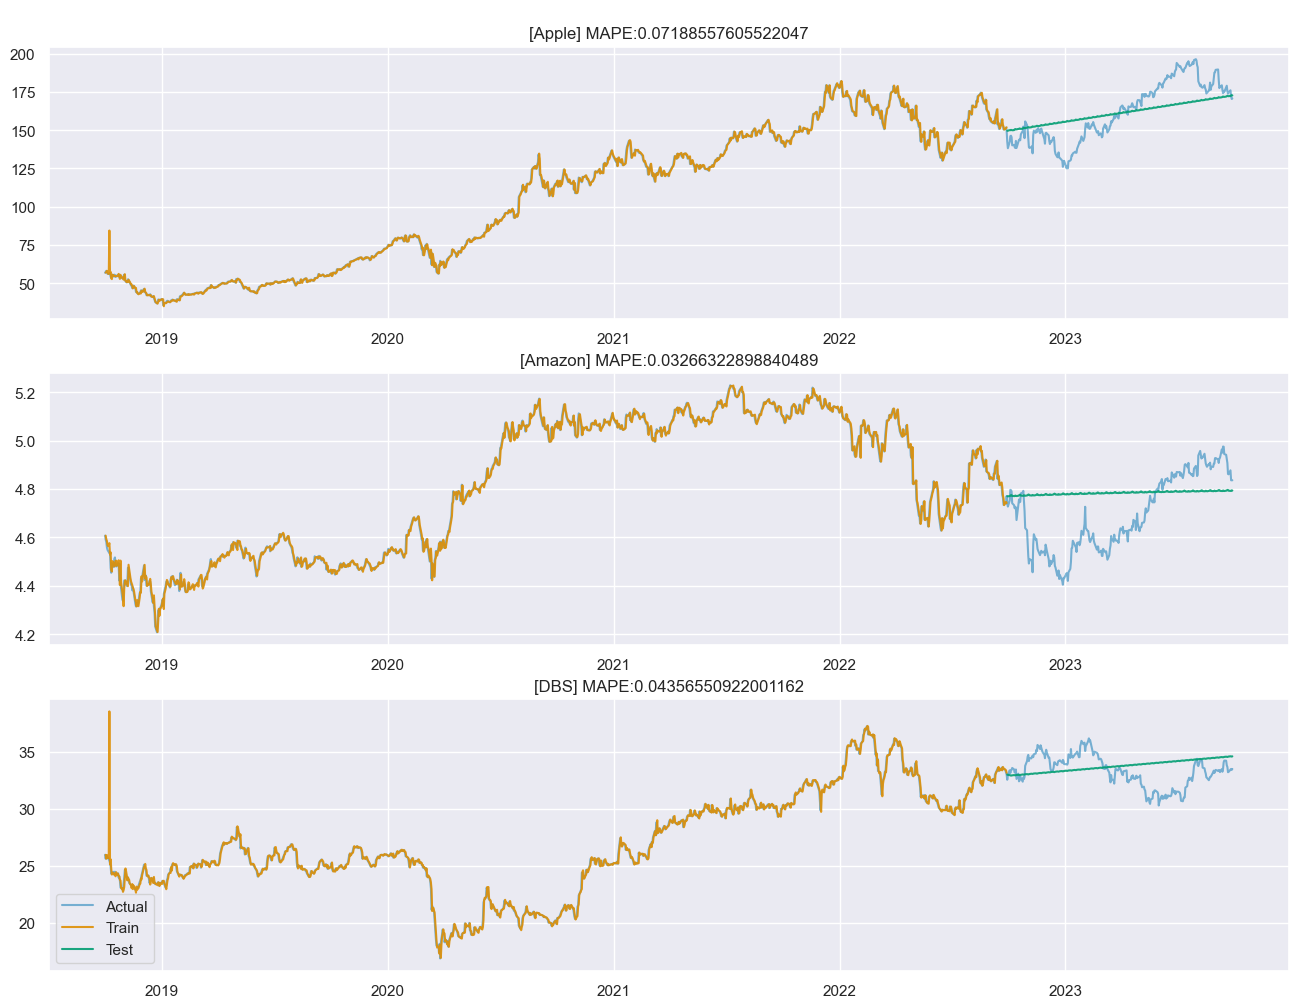

In [167]:
orders = [((3,1,2),(1,1,2,7)),((1,0,2),(2,0,2,7)),((2,1,3),(1,1,2,7))]

fig, axes = plt.subplots(3,1, figsize=(16, 12))

for idx, (order, seasonal_order) in enumerate(orders):
    mod = SARIMAX(train_data[df_train.columns[idx]], order = order, seasonal_order = seasonal_order)
    res = mod.fit()

    full_pred = res.predict()
    pred = res.forecast(365)

    axes[idx].set_title("\n[{}] MAPE:{}".format(df_train.columns[idx], mean_absolute_percentage_error(test_data[df_train.columns[idx]],pred)))
    axes[idx].plot(df_train[df_train.columns[idx]], label = 'Actual', alpha=0.5)
    axes[idx].plot(full_pred.iloc[1:], label = 'Train', alpha=0.9)
    axes[idx].plot(pred, label='Test', alpha=0.9)
plt.legend()
plt.show()

<hr></hr>
<h3>Final Predictions</h3>
<hr></hr>


Overall, the models we will be using to forecast each time series are:

- <b>Amazon:</b> SARIMAX
- <b>Apple:</b> ARIMA
- <b>DBS:</b> ARIMA

We now want to train each model with the entire time series, and try to make predictions for the next 60 Days.

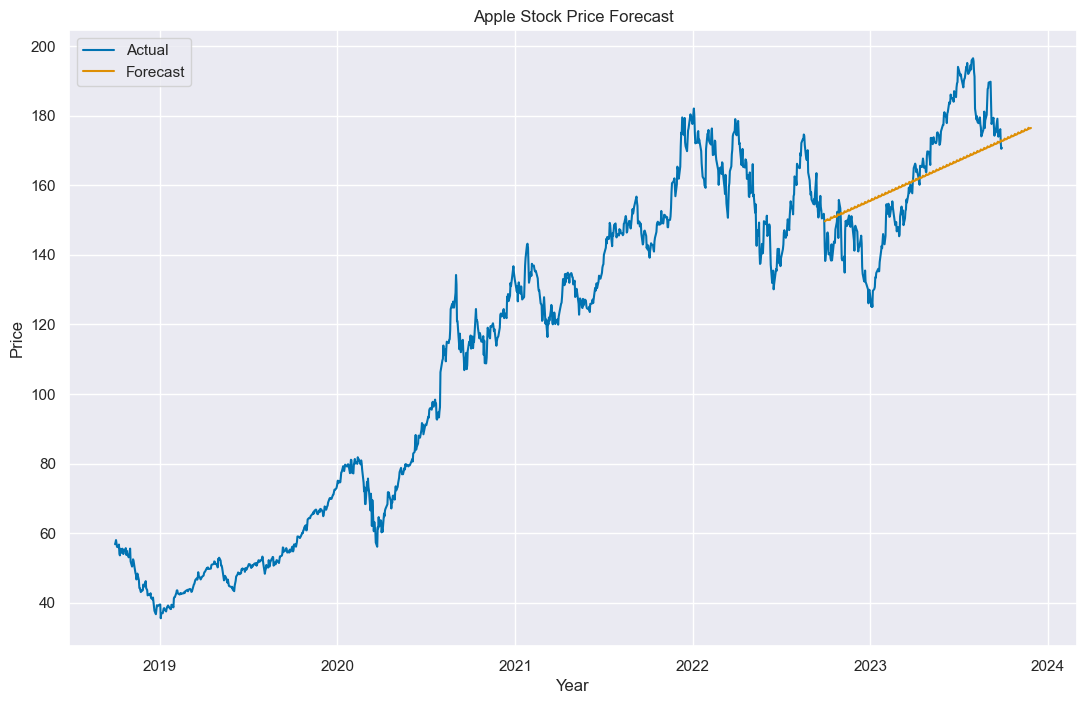

In [171]:
fig, axes = plt.figure(figsize=(13,8)), plt.gca()
Apple_mod = SARIMAX(train_data["Apple"], order = (3,1,2), seasonal_order = (1,1,2,7))
res = Apple_mod.fit()
pred = res.forecast(425)

axes.plot(df_train["Apple"], label = 'Actual')
axes.plot(pred, label='Forecast')

axes.set_title("Apple Stock Price Forecast")
plt.xlabel("Year")
plt.ylabel("Price")
plt.legend()
plt.show()


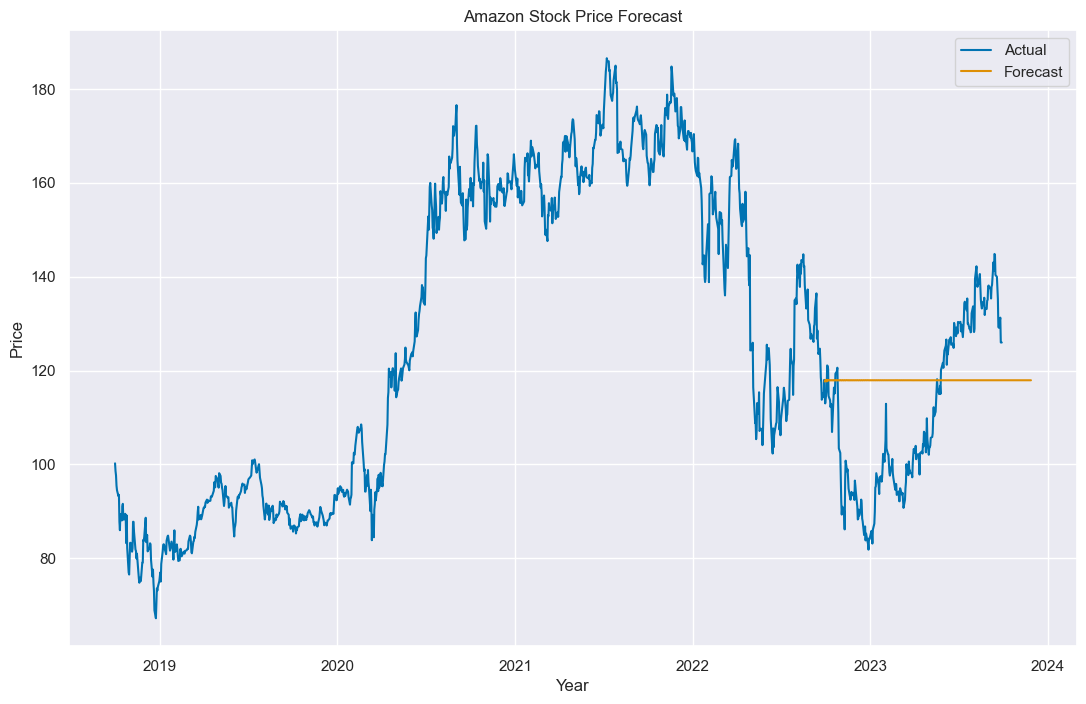

In [173]:
fig, axes = plt.figure(figsize=(13,8)), plt.gca()
mod = ARIMA(np.exp(train_data["Amazon"]), order = (8,1,2))
res = mod.fit()
pred = res.forecast(425)

axes.plot(np.exp(df_train["Amazon"]), label = 'Actual')
axes.plot(pred, label='Forecast')

axes.set_title("Amazon Stock Price Forecast")
plt.xlabel("Year")
plt.ylabel("Price")
plt.legend()
plt.show()


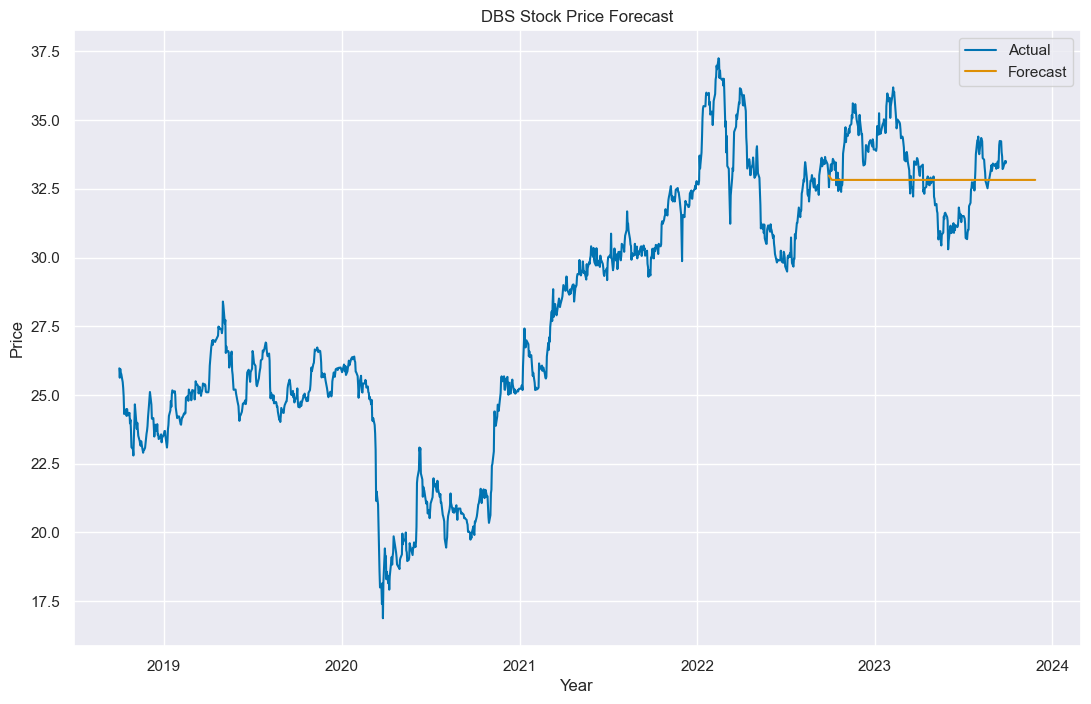

In [170]:
fig, axes = plt.figure(figsize=(13,8)), plt.gca()
mod = ARIMA(train_data["DBS"], order = (0,1,8))
res = mod.fit()
pred = res.forecast(425)

axes.plot(df_train["DBS"], label = 'Actual')
axes.plot(pred, label='Forecast')

axes.set_title("DBS Stock Price Forecast")
plt.xlabel("Year")
plt.ylabel("Price")
plt.legend()
plt.show()

<hr></hr>
<h3>Conclusion</h3>
<hr></hr>

